## imports

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
plt.style.use('dark_background')
import time

load the dataset

In [2]:
data = pd.read_csv('winequality.csv')
df = data.copy()
df

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.700,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,5
1,7.8,0.880,0.00,2.6,0.098,25.0,67.0,0.99680,3.20,0.68,9.8,5
2,7.8,0.760,0.04,2.3,0.092,15.0,54.0,0.99700,3.26,0.65,9.8,5
3,11.2,0.280,0.56,1.9,0.075,17.0,60.0,0.99800,3.16,0.58,9.8,6
4,7.4,0.700,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,5
...,...,...,...,...,...,...,...,...,...,...,...,...
1594,6.2,0.600,0.08,2.0,0.090,32.0,44.0,0.99490,3.45,0.58,10.5,5
1595,5.9,0.550,0.10,2.2,0.062,39.0,51.0,0.99512,3.52,0.76,11.2,6
1596,6.3,0.510,0.13,2.3,0.076,29.0,40.0,0.99574,3.42,0.75,11.0,6
1597,5.9,0.645,0.12,2.0,0.075,32.0,44.0,0.99547,3.57,0.71,10.2,5


In [3]:
df.isnull().sum()

fixed acidity           0
volatile acidity        0
citric acid             0
residual sugar          0
chlorides               0
free sulfur dioxide     0
total sulfur dioxide    0
density                 0
pH                      0
sulphates               0
alcohol                 0
quality                 0
dtype: int64

In [4]:
df['quality'].unique()

array([5, 6, 7, 4, 8, 3])

In [5]:
scaler = StandardScaler()

In [6]:
X = df.iloc[:,0:11].values
y = df.iloc[:,11].values

X_std = scaler.fit_transform(X)

In [7]:
print(y)

[5 5 5 ... 6 5 6]


calculate the class means - the means for each separate quality grade of wine

In [8]:
np.set_printoptions(precision=1)

mean_vectors=[]
for gr in range(3,9):
    mean_vectors.append(np.mean(X_std[y==gr],axis=0))
    print('Mean vector quality %s :%s\n' %(gr,mean_vectors[gr-3]))

Mean vector quality 3 :[ 0.   2.  -0.5  0.1  0.7 -0.5 -0.7  0.4  0.6 -0.5 -0.4]

Mean vector quality 4 :[-0.3  0.9 -0.5  0.1  0.1 -0.3 -0.3 -0.1  0.5 -0.4 -0.1]

Mean vector quality 5 :[-0.1  0.3 -0.1 -0.   0.1  0.1  0.3  0.2 -0.  -0.2 -0.5]

Mean vector quality 6 :[ 0.  -0.2  0.  -0.  -0.1 -0.  -0.2 -0.1  0.   0.1  0.2]

Mean vector quality 7 :[ 0.3 -0.7  0.5  0.1 -0.2 -0.2 -0.3 -0.3 -0.1  0.5  1. ]

Mean vector quality 8 :[ 0.1 -0.6  0.6  0.  -0.4 -0.2 -0.4 -0.8 -0.3  0.6  1.6]



### Calculate the within - and between-class scatter matrices

In [9]:
S_w = np.zeros((11,11))

for gr, mv in zip(range(3,9), mean_vectors):
    class_sc_mat = np.zeros((11,11))

    for row in X_std[y==gr]:
        row,mv = row.reshape(11,1), mv.reshape(11,1)
        class_sc_mat+=(row-mv).dot((row-mv).T)

    S_w+=class_sc_mat
print('Within class-scatter matrix:\n', S_w)        

Within class-scatter matrix:
 [[ 1.6e+03 -3.3e+02  1.0e+03  1.8e+02  1.7e+02 -2.3e+02 -1.4e+02  1.1e+03
  -1.1e+03  2.4e+02 -2.0e+02]
 [-3.3e+02  1.3e+03 -7.4e+02  1.1e+01  1.7e+01 -3.9e+01  2.3e+01 -6.5e+01
   3.3e+02 -2.6e+02 -4.3e+01]
 [ 1.0e+03 -7.4e+02  1.5e+03  2.2e+02  3.7e+02 -7.7e+01  1.2e+02  6.5e+02
  -8.4e+02  4.1e+02 -7.7e-01]
 [ 1.8e+02  1.1e+01  2.2e+02  1.6e+03  9.3e+01  3.1e+02  3.3e+02  5.8e+02
  -1.4e+02  1.9e-01  4.6e+01]
 [ 1.7e+02  1.7e+01  3.7e+02  9.3e+01  1.6e+03 -4.9e+00  3.4e+01  2.8e+02
  -4.3e+02  6.5e+02 -2.5e+02]
 [-2.3e+02 -3.9e+01 -7.7e+01  3.1e+02 -4.9e+00  1.6e+03  1.0e+03 -6.5e+01
   1.2e+02  1.1e+02 -3.7e+01]
 [-1.4e+02  2.3e+01  1.2e+02  3.3e+02  3.4e+01  1.0e+03  1.5e+03  3.8e+01
  -9.3e+01  1.5e+02 -1.3e+02]
 [ 1.1e+03 -6.5e+01  6.5e+02  5.8e+02  2.8e+02 -6.5e+01  3.8e+01  1.5e+03
  -5.5e+02  3.1e+02 -6.3e+02]
 [-1.1e+03  3.3e+02 -8.4e+02 -1.4e+02 -4.3e+02  1.2e+02 -9.3e+01 -5.5e+02
   1.6e+03 -3.0e+02  3.5e+02]
 [ 2.4e+02 -2.6e+02  4.1e+02  1.9e

### Calculate the between class scatter matrix

In [10]:
overall_mean = np.mean(X_std, axis=0)
c=0
S_b=np.zeros((11,11))
for i, mean_vec in enumerate(mean_vectors):
    n=X_std[y==i+3,:].shape[0]
    c+=1
    mean_vec=mean_vec.reshape(11,1)
    overall_mean=overall_mean.reshape(11,1)
    S_b+=n*(mean_vec-overall_mean).dot((mean_vec-overall_mean).T)

print('Bettween class scatter matrix:\n', S_b)    

Bettween class scatter matrix:
 [[  30.9  -78.1   52.     6.4  -23.8  -12.6  -38.   -33.7  -13.6   52.6
    99.5]
 [ -78.1  256.6 -142.7   -7.9   81.    22.    99.4  100.7   42.5 -154.7
  -280.3]
 [  52.  -142.7   93.1   11.   -45.9  -20.2  -60.6  -63.1  -27.9   93.6
   176.5]
 [   6.4   -7.9   11.     5.3   -4.3   -7.    -8.1   -8.5   -1.5    8.7
    21.7]
 [ -23.8   81.   -45.9   -4.3   29.7   13.8   42.    40.8    9.4  -52.6
  -104.3]
 [ -12.6   22.   -20.2   -7.    13.8   23.5   46.4   30.1   -8.4  -27.7
   -73.7]
 [ -38.    99.4  -60.6   -8.1   42.    46.4  118.4   75.6  -13.2  -85.8
  -196.9]
 [ -33.7  100.7  -63.1   -8.5   40.8   30.1   75.6   64.5    5.5  -75.4
  -162. ]
 [ -13.6   42.5  -27.9   -1.5    9.4   -8.4  -13.2    5.5   21.5  -19.
   -20.8]
 [  52.6 -154.7   93.6    8.7  -52.6  -27.7  -85.8  -75.4  -19.   104.5
   204.9]
 [  99.5 -280.3  176.5   21.7 -104.3  -73.7 -196.9 -162.   -20.8  204.9
   426.4]]


### Find the eigenvectors and eigenvalues pairs

In [11]:
eigs_vals, eigs_vecs = np.linalg.eig(np.linalg.inv(S_w).dot(S_b))

In [12]:
eigs_vals

array([ 6.3e-01+0.0e+00j,  7.6e-02+0.0e+00j,  2.5e-02+0.0e+00j,
        6.4e-03+0.0e+00j,  4.2e-03+0.0e+00j,  1.2e-16+0.0e+00j,
        5.6e-17+0.0e+00j, -3.8e-17+2.7e-17j, -3.8e-17-2.7e-17j,
       -1.6e-17+0.0e+00j,  1.1e-17+0.0e+00j])

In [13]:
eigs_vecs

array([[ 0.2+0.j , -0.5+0.j ,  0.1+0.j ,  0.7+0.j , -0.2+0.j ,  0. +0.j ,
         0.5+0.j ,  0.3+0.1j,  0.3-0.1j, -0.3+0.j , -0.6+0.j ],
       [-0.4+0.j , -0.5+0.j ,  0.3+0.j , -0.2+0.j ,  0.3+0.j ,  0.1+0.j ,
        -0.2+0.j ,  0.1-0.1j,  0.1+0.1j, -0. +0.j ,  0. +0.j ],
       [-0. +0.j , -0.2+0.j ,  0.4+0.j , -0.1+0.j ,  0.3+0.j ,  0.3+0.j ,
        -0.5+0.j , -0.4-0.2j, -0.4+0.2j,  0.2+0.j ,  0.3+0.j ],
       [ 0.1+0.j , -0.2+0.j ,  0.2+0.j ,  0.2+0.j , -0.4+0.j ,  0.1+0.j ,
        -0.2+0.j ,  0. -0.1j,  0. +0.1j, -0.2+0.j ,  0.4+0.j ],
       [-0.2+0.j , -0.1+0.j , -0.1+0.j ,  0.1+0.j ,  0.2+0.j ,  0.1+0.j ,
         0.2+0.j , -0.4+0.1j, -0.4-0.1j, -0.3+0.j ,  0.2+0.j ],
       [ 0.1+0.j ,  0. +0.j , -0.4+0.j , -0.1+0.j ,  0.4+0.j ,  0.3+0.j ,
        -0.3+0.j , -0.2-0.3j, -0.2+0.3j, -0.6+0.j ,  0.4+0.j ],
       [-0.3+0.j ,  0.3+0.j ,  0.5+0.j ,  0.1+0.j , -0.2+0.j , -0.1+0.j ,
         0.2+0.j , -0.2+0.2j, -0.2-0.2j, -0.3+0.j , -0.2+0.j ],
       [-0.2+0.j ,  0.5+0.j , -0.5

In [14]:
for i in range(len(eigs_vals)):
    eigvec_sc=eigs_vecs[:,i].reshape(11,1)
    print('\nEigenvector {}:\n{}' .format(i+1, eigvec_sc.real))
    print('\nEigenvalue {:}:\n{:.2e}' .format(i+1,eigs_vals[i].real))


Eigenvector 1:
[[ 0.2]
 [-0.4]
 [-0. ]
 [ 0.1]
 [-0.2]
 [ 0.1]
 [-0.3]
 [-0.2]
 [-0. ]
 [ 0.4]
 [ 0.7]]

Eigenvalue 1:
6.32e-01

Eigenvector 2:
[[-0.5]
 [-0.5]
 [-0.2]
 [-0.2]
 [-0.1]
 [ 0. ]
 [ 0.3]
 [ 0.5]
 [-0.4]
 [-0.1]
 [ 0.1]]

Eigenvalue 2:
7.64e-02

Eigenvector 3:
[[ 0.1]
 [ 0.3]
 [ 0.4]
 [ 0.2]
 [-0.1]
 [-0.4]
 [ 0.5]
 [-0.5]
 [-0.1]
 [ 0.1]
 [-0.1]]

Eigenvalue 3:
2.48e-02

Eigenvector 4:
[[ 0.7]
 [-0.2]
 [-0.1]
 [ 0.2]
 [ 0.1]
 [-0.1]
 [ 0.1]
 [-0.4]
 [ 0.4]
 [-0. ]
 [-0.3]]

Eigenvalue 4:
6.43e-03

Eigenvector 5:
[[-0.2]
 [ 0.3]
 [ 0.3]
 [-0.4]
 [ 0.2]
 [ 0.4]
 [-0.2]
 [ 0.5]
 [-0.2]
 [-0.1]
 [ 0.4]]

Eigenvalue 5:
4.18e-03

Eigenvector 6:
[[ 0. ]
 [ 0.1]
 [ 0.3]
 [ 0.1]
 [ 0.1]
 [ 0.3]
 [-0.1]
 [-0.6]
 [ 0.4]
 [ 0.3]
 [-0.4]]

Eigenvalue 6:
1.20e-16

Eigenvector 7:
[[ 0.5]
 [-0.2]
 [-0.5]
 [-0.2]
 [ 0.2]
 [-0.3]
 [ 0.2]
 [-0.1]
 [-0.2]
 [-0.5]
 [ 0.2]]

Eigenvalue 7:
5.61e-17

Eigenvector 8:
[[ 0.3]
 [ 0.1]
 [-0.4]
 [ 0. ]
 [-0.4]
 [-0.2]
 [-0.2]
 [ 0.1]
 [-0.5]
 [ 0.1]
 

### Order the eigen pairs in descending order with respect to the egenvalues

In [15]:
eig_pairs = []
for i in range(len(eigs_vals)):
    if eigs_vals[i]<0:
        eig_pairs.append((-eigs_vals[i],-eigs_vecs[:,i]))
    else:
        eig_pairs.append((eigs_vals[i],eigs_vecs[:,i]))
eig_pairs = sorted(eig_pairs, key= lambda k: k[0], reverse = True)

print('Evalues in decresing order:\n')
for i in range(len(eig_pairs)):
    print('Evalue:\n')
    print(eig_pairs[i][0].real)
    print('\n')
    print('Associated evector:\n')
    print(eig_pairs[i][1].real)
    print('\n')

Evalues in decresing order:

Evalue:

0.6318983806659387


Associated evector:

[ 0.2 -0.4 -0.   0.1 -0.2  0.1 -0.3 -0.2 -0.   0.4  0.7]


Evalue:

0.07644038712342205


Associated evector:

[-0.5 -0.5 -0.2 -0.2 -0.1  0.   0.3  0.5 -0.4 -0.1  0.1]


Evalue:

0.02479746521139609


Associated evector:

[ 0.1  0.3  0.4  0.2 -0.1 -0.4  0.5 -0.5 -0.1  0.1 -0.1]


Evalue:

0.006428277646001661


Associated evector:

[ 0.7 -0.2 -0.1  0.2  0.1 -0.1  0.1 -0.4  0.4 -0.  -0.3]


Evalue:

0.004179959145044563


Associated evector:

[-0.2  0.3  0.3 -0.4  0.2  0.4 -0.2  0.5 -0.2 -0.1  0.4]


Evalue:

1.1985314150763733e-16


Associated evector:

[ 0.   0.1  0.3  0.1  0.1  0.3 -0.1 -0.6  0.4  0.3 -0.4]


Evalue:

5.6072528375366e-17


Associated evector:

[ 0.5 -0.2 -0.5 -0.2  0.2 -0.3  0.2 -0.1 -0.2 -0.5  0.2]


Evalue:

3.841253282858753e-17


Associated evector:

[-0.3 -0.1  0.4 -0.   0.4  0.2  0.2 -0.1  0.5 -0.1  0.2]


Evalue:

3.841253282858753e-17


Associated evector:

[-0.3 -0.1  0.4 -0.   0

Show the explained variance by each respective eigenvector

In [16]:
print('Variance explained :\n')
eigv_sum = sum(eigs_vals)
for i, j in enumerate(eig_pairs):
    print('eigvalue {0:}: {1:.2%}'.format(i+1,(j[0].real/eigv_sum.real)))

Variance explained :

eigvalue 1: 84.96%
eigvalue 2: 10.28%
eigvalue 3: 3.33%
eigvalue 4: 0.86%
eigvalue 5: 0.56%
eigvalue 6: 0.00%
eigvalue 7: 0.00%
eigvalue 8: 0.00%
eigvalue 9: 0.00%
eigvalue 10: 0.00%
eigvalue 11: 0.00%


### Take the first two eigvectors retaining the most variance

In [17]:
W = np.hstack((eig_pairs[0][1].reshape(11,1), eig_pairs[1][1].reshape(11,1)))
print('Matrix W:\n', W.real)

Matrix W:
 [[ 0.2 -0.5]
 [-0.4 -0.5]
 [-0.  -0.2]
 [ 0.1 -0.2]
 [-0.2 -0.1]
 [ 0.1  0. ]
 [-0.3  0.3]
 [-0.2  0.5]
 [-0.  -0.4]
 [ 0.4 -0.1]
 [ 0.7  0.1]]


### Project the data onto the new axes (linear discriminants)

In [18]:
X_lda = X_std.dot(W)

In [19]:
X_std.shape

(1599, 11)

In [20]:
W.shape

(11, 2)

In [21]:
X_lda.shape

(1599, 2)

### Plot the Dataset after performing LDA

In [22]:
def plot_step_lda():
    fig=plt.figure()

    ax= plt.subplot(111)
    for label, color in zip(range(3,9),('blue', 'red', 'green', 'yellow', 'white', 'orange')):

        plt.scatter(x=X_lda[:,0].real[y==label],
                    y=X_lda[:,1].real[y==label],
                    color=color,
                    alpha=0.5,
                    label=label
                    )
    plt.xlabel('Linear Discriminant 1')
    plt.ylabel('Linear Discriminant 2')   

    leg = plt.legend(loc='upper right', fancybox=True)
    leg.get_frame().set_alpha(0.5)
    plt.title('LDA: Wine data projection onto the first 2 linear discriminants')

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)

    plt.grid()
    plt.show()             

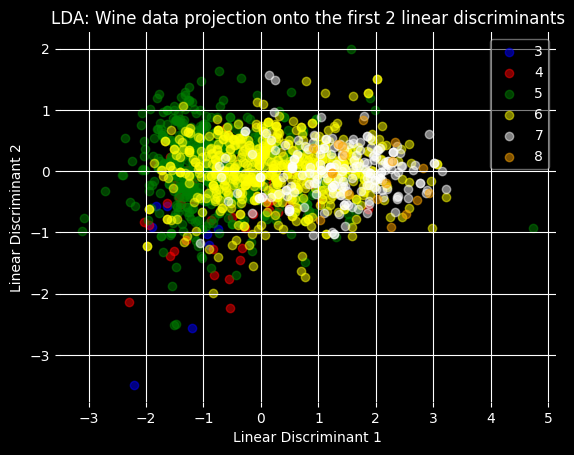

In [23]:
plot_step_lda()

### add the plot when ising PCA

In [24]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_std)

### plot dataset after performing PCA

In [25]:
def plot_step_pca():
    fig=plt.figure()

    ax=plt.subplot(111)
    for label, color in zip(range(3,9),('blue', 'red', 'green', 'yellow', 'white', 'orange')):
        plt.scatter(x=X_pca[:,0].real[y==label],
                    y=X_pca[:,1].real[y==label],
                    color=color,
                    alpha=0.5,
                    label=label
                    )
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')

    leg = plt.legend(loc='upper right', fancybox=True)
    leg.get_frame().set_alpha(0.5)
    plt.title('PCA: Wine data projection onto the first 2 principal componets')

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)

    plt.grid()
    plt.show()                

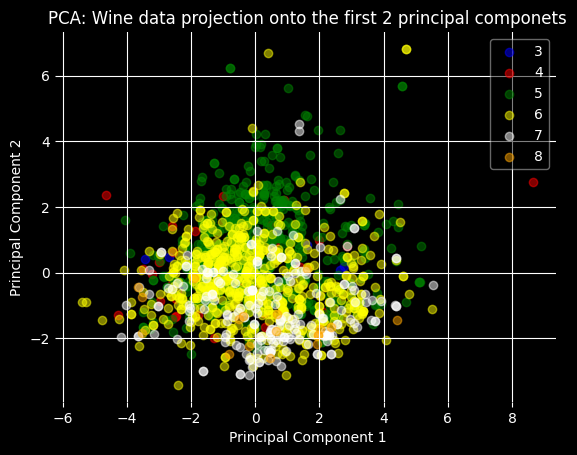

In [26]:
plot_step_pca()

### Setting up the classifier to compare PCA and LDA

In [27]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=0)

In [28]:
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

### Perform LDA with 2 linear discriminants and store the respective results from the training and testing parts 

In [29]:
lda = LDA(n_components=2)
X_train_lda = lda.fit_transform(X_train, y_train)
X_test_lda = lda.transform(X_test)

### Perform PCA with 2 principal components and store the respective results from the training and testing parts

In [30]:
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

### import the classifier

In [31]:
svclassifier = SVC(kernel='linear')

### Run the classifier through the LDA train and test sets and return the necessary time for training and testing

In [32]:
def train_test_lda():
    s=[]
    start_train_lda=time.time()
    svclassifier.fit(X_train_lda,y_train)
    finish_train_lda = time.time()

    start_test_lda = time.time()
    y_pred_lda = svclassifier.predict(X_test_lda)
    finish_test_lda = time.time()

    s.append(finish_train_lda-start_train_lda)
    s.append(finish_test_lda-start_test_lda)
    s.append(y_pred_lda)

    return s

### Run the classifier through the PCA train and test sets and return the necessary time for training and testing

In [33]:
def train_test_pca():
    s=[]
    start_train_pca=time.time()
    svclassifier.fit(X_train_pca,y_train)
    finish_train_pca = time.time()

    start_test_pca = time.time()
    y_pred_pca = svclassifier.predict(X_test_pca)
    finish_test_pca = time.time()

    s.append(finish_train_pca-start_train_pca)
    s.append(finish_test_pca-start_test_pca)
    s.append(y_pred_pca)

    return s

### Analysis of the training and testing times for the classifier and its accurancy

In [34]:
train_lda=0
test_lda=0
for i in range(10):
    c=train_test_lda()
    train_lda+=c[0]
    test_lda+=c[1]

print('Average time for training out of 10 runs for LDA:{}'.format(train_lda/10))
print('average time for testing out of 10 runs for LDA:{}'.format(test_lda/10))    

Average time for training out of 10 runs for LDA:0.03613169193267822
average time for testing out of 10 runs for LDA:0.008026027679443359


In [36]:
train_pca=0
test_pca=0
for i in range(10):
    m=train_test_pca()
    train_pca+=m[0]
    test_pca+=m[1]

print('Average time for training out of 10 runs for PCA:{}'.format(train_pca/10))
print('Averange time for testing out of 10 rund for PCA:{}'.format(test_pca/10))    

Average time for training out of 10 runs for PCA:0.0419959306716919
Averange time for testing out of 10 rund for PCA:0.008248114585876464


In [37]:
a = train_test_lda()
b = train_test_pca()

### Print out the confusion matrix for the LDA test set

In [38]:
cm_lda = confusion_matrix(y_test, a[2])
print('Confusion matrix for LDA:\n')
print(cm_lda)
print('\n')
print('LDA Accuracy:'+' '+ str(accuracy_score(y_test, a[2])))

Confusion matrix for LDA?

[[  0   0   2   0   0   0]
 [  0   0   6   5   0   0]
 [  0   0 107  28   0   0]
 [  0   0  45  97   0   0]
 [  0   0   1  26   0   0]
 [  0   0   0   3   0   0]]


LDA Accuracy: 0.6375


In [39]:
cm_pca = confusion_matrix(y_test, b[2])
print('Confusion matrix for PCA:\n')
print(cm_pca)
print('\n')
print('PCA Accuracy:'+' '+ str(accuracy_score(y_test, b[2])))

Confusion matrix for PCA:

[[ 0  0  0  2  0  0]
 [ 0  0  4  7  0  0]
 [ 0  0 87 48  0  0]
 [ 0  0 54 88  0  0]
 [ 0  0  4 23  0  0]
 [ 0  0  0  3  0  0]]


PCA Accuracy: 0.546875
